In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import *

from models import caranet
from unet import pretrained_unet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
##### Hyperparameter Settings ####
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
random_seed = 42
augmentation_type = 1

# model_type = 'caranet'
model_type = 'unet'

filename = f'models/pre_both_{augmentation_type}_{model_type}.pt'

if model_type == 'unet':
    mode = 'base'
elif model_type == 'caranet':
    mode = 'caranet'
#################################

In [5]:
# transform = A.Compose([
#     ToTensorV2(transpose_mask=True)
# ])

transform = False

train_loader, val_loader = make_dataloader('A2C', transform , random_seed, batch_size, mode)

train img shape : (800, 400, 400, 3), train mask shape : (800, 400, 400, 1)
test img shape : (100, 400, 400, 3), test mask shape : (100, 400, 400, 1)


In [6]:
img, target = next(iter(val_loader))
img = img.to(device)
target = target.to(device)

img.shape

torch.Size([16, 3, 400, 400])

In [7]:
if model_type == 'unet':
    model = pretrained_unet(True).to(device)
    
elif model_type == 'caranet':
    model = caranet().to(device)

In [8]:
filename = 'models/pre_both_1_unet/model_9.pt'
model.load_state_dict(torch.load(f'{filename}'))

<All keys matched successfully>

In [9]:
y_pred = model(img.float())

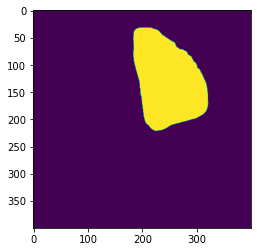

In [10]:
plt.imshow(y_pred[0].cpu().detach().numpy().transpose(1,2,0))
plt.show()

In [13]:
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

In [14]:
def resize_return(y_pred, cutoff, originsize, pad_size): ## cutoff, originsize(tuple)
    h, w = originsize
    h -= cutoff

    inverse = transforms.Compose([
                                transforms.Pad(padding=(pad_size, 0), fill=0),
                                transforms.Resize((h,w), interpolation=InterpolationMode.NEAREST),
                                transforms.Pad(padding=(0,cutoff,0,0), fill=0)
                                 ])
    
    y_pred_inverse = inverse(y_pred)
    print(y_pred_inverse.shape)

    return y_pred_inverse

In [15]:
li = []
with open('data/validation_A2C_size.csv', 'r') as fr:
    while True:
        data = fr.readline()

        if not data:
            break

        li.append(data.split(','))

li = li[1:]
print(len(li))

index = 2

cutoff = li[index][3]
h, w = li[index][1], li[index][2]

y_pred_inverse = resize_return(y_pred[index], int(cutoff), (int(h), int(w)), pad_size=100)

100
torch.Size([1, 434, 636])


In [16]:
origin_mask = np.load('data/original/validation/A2C/0803.npy')
origin_mask.shape

(434, 636)

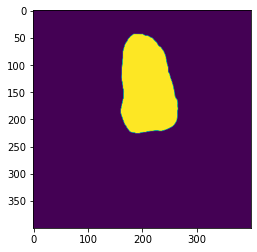

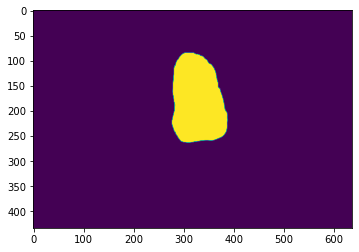

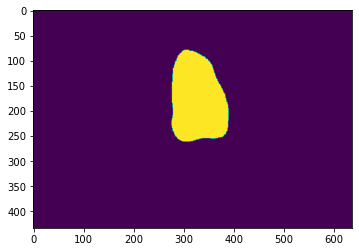

In [17]:
plt.imshow(y_pred[index].cpu().detach().numpy().transpose(1,2,0))
plt.show()

plt.imshow(y_pred_inverse.cpu().detach().numpy().transpose(1,2,0))
plt.show()

plt.imshow(origin_mask)
plt.show()